In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import glob
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils
from keras.callbacks import *


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# PROCESS

In [ ]:
# rank 5 accuracy: does the model predict ground truth in top 5 predictions by probability
def rankacc(X_test, test_class, model):
  """
  X_test: array of input data for the model
  test_class: array of correct classes for input data
  model: the trained model for making predictions
  """
  y_pred_5 = []
  y_pred_1 = []
  for i in range(X_test.shape[0]):
    item = X_test[i]
    preds = model.predict(np.array([item]))
    preds = np.argsort(preds[0,:])[::-1][:5]
    if test_class[i] in preds: y_pred_5.append(1)
    else: y_pred_5.append(0)
    if test_class[i] == preds[0]: y_pred_1.append(1)
    else: y_pred_1.append(0)
  
  score5 = sum(y_pred_5)/len(y_pred_5)
  score1 = sum(y_pred_1)/len(y_pred_1)
  print("Score 5: ", score5, ", Score 1: ", score1)

In [ ]:
path_classes = "/content/drive/MyDrive/assignment3/data/perfectly_detected_ears/annotations/recognition/ids.csv"
path_train = "/content/drive/MyDrive/assignment3/data/perfectly_detected_ears/train"
path_test = "/content/drive/MyDrive/assignment3/data/perfectly_detected_ears/test"

In [ ]:
f = open(path_classes, "r")
test_class_picture_dict = {}
train_class_picture_dict = {}

In [ ]:
# read annotation image x class
# start classes with 0 not with 1
for line in f.readlines():
  image, class_name = line.strip("\n").split(",")
  if image.startswith("train"):
    if image in train_class_picture_dict.keys(): print("doubled image")
    train_class_picture_dict[image] = int(class_name)-1
  elif image.startswith("test"):
    if image in test_class_picture_dict.keys(): print("doubled image")
    test_class_picture_dict[image] = int(class_name)-1

In [ ]:
test_class = np.array(list(test_class_picture_dict.values()), dtype=int)
train_class = np.array(list(train_class_picture_dict.values()), dtype=int)

In [ ]:
filename = "/content/drive/MyDrive/assignment3/data/perfectly_detected_ears/test/0015.png"

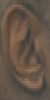

In [ ]:
img = cv2.resize(cv2.imread(filename), (50, 100), interpolation = cv2.INTER_AREA)
cv2_imshow(img)

In [ ]:
# read and process images
im_list = sorted(glob.glob(path_train + '/*.png', recursive=True))
images_train = []
for im_name in im_list:
  img = cv2.resize(cv2.imread(im_name), (100, 50), interpolation = cv2.INTER_AREA)
  images_train.append(img)

im_list = sorted(glob.glob(path_test + '/*.png', recursive=True))
images_test = []
for im_name in im_list:
  img = cv2.resize(cv2.imread(im_name), (100, 50), interpolation = cv2.INTER_AREA)
  images_test.append(img)

images_train = np.array(images_train)
images_test = np.array(images_test)

In [ ]:
X_train, y_train, X_test, y_test = images_train.astype('float32'), train_class, images_test.astype('float32'), test_class

X_train = X_train.reshape(X_train.shape[0], 100, 50, 3)
X_test = X_test.reshape(X_test.shape[0], 100, 50, 3)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

ValueError: ignored

In [ ]:
min(y_train)

0

In [ ]:
n_classes = len(set(list(y_train)+list(y_test)))
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

Shape before one-hot encoding:  (750,)
Shape after one-hot encoding:  (750, 100)


# FIRST TRY

In [ ]:
# https://www.analyticsvidhya.com/blog/2020/02/learn-image-classification-cnn-convolutional-neural-networks-3-datasets/
# building a linear stack of layers with the sequential model
model = Sequential()

# convolutional layer
model.add(Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(100, 50, 3)))

# convolutional layer
model.add(Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(125, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# flatten output of conv
model.add(Flatten())

# hidden layer
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(100, activation='softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')


In [ ]:
# training the model for 10 epochs
filepath_model = "/content/drive/MyDrive/assignment3/detectors/firstCNN/epochs:{epoch:03d}-val_acc:{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath_model, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(X_train, Y_train, batch_size=128, epochs=50, validation_data=(X_test, Y_test), callbacks=callbacks_list)

Epoch 1/50
6/6 [==============================] - ETA: 0s - loss: 4.8245 - accuracy: 0.0080
Epoch 00001: val_accuracy improved from -inf to 0.00800, saving model to /content/drive/MyDrive/assignment3/detectors/firstCNN/epochs:001-val_acc:0.008.hdf5
6/6 [==============================] - 18s 1s/step - loss: 4.8245 - accuracy: 0.0080 - val_loss: 4.6056 - val_accuracy: 0.0080
Epoch 2/50
6/6 [==============================] - ETA: 0s - loss: 4.6071 - accuracy: 0.0120
Epoch 00002: val_accuracy improved from 0.00800 to 0.01200, saving model to /content/drive/MyDrive/assignment3/detectors/firstCNN/epochs:002-val_acc:0.012.hdf5
6/6 [==============================] - 2s 379ms/step - loss: 4.6071 - accuracy: 0.0120 - val_loss: 4.6072 - val_accuracy: 0.0120
Epoch 3/50
6/6 [==============================] - ETA: 0s - loss: 4.6064 - accuracy: 0.0120
Epoch 00003: val_accuracy did not improve from 0.01200
6/6 [==============================] - 1s 216ms/step - loss: 4.6064 - accuracy: 0.0120 - val_los

In [ ]:
model.save('/content/drive/MyDrive/assignment3/detectors/firstCNN')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/assignment3/detectors/firstCNN/assets


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


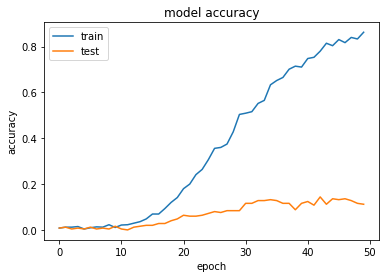

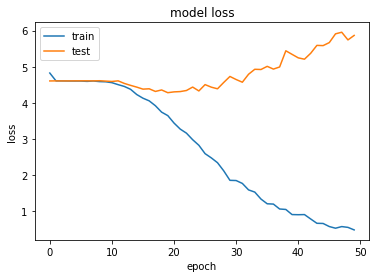

In [ ]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

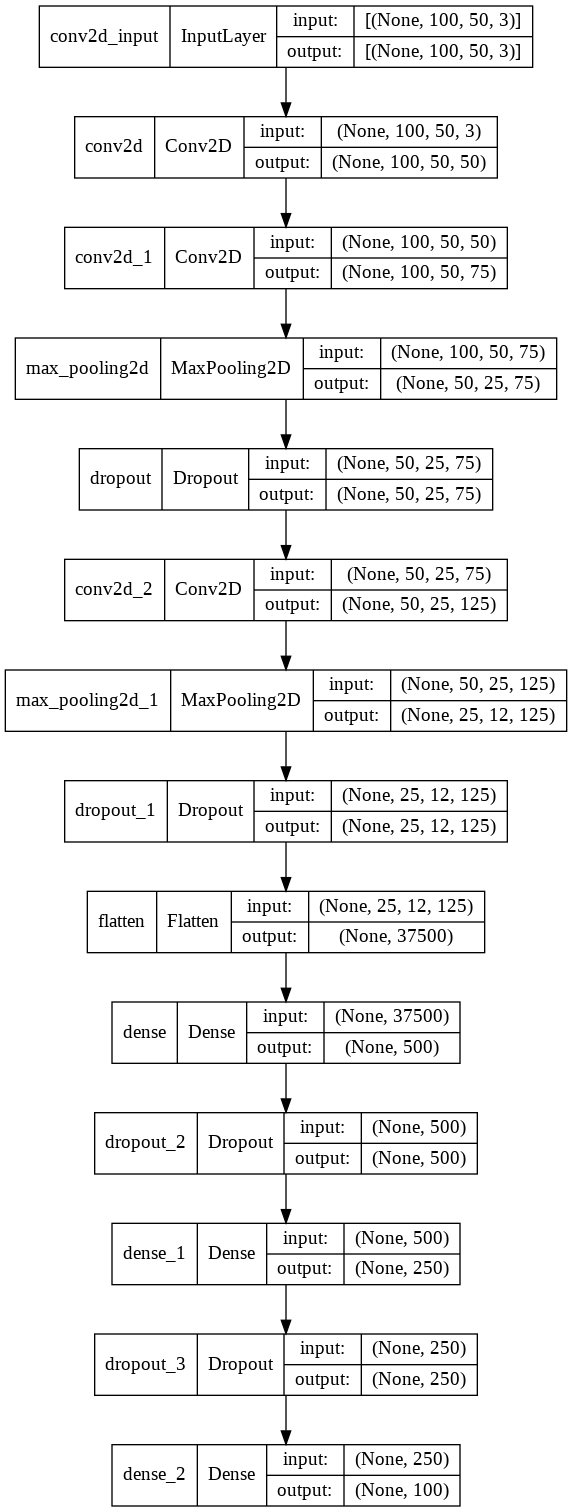

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
filename = "/content/drive/MyDrive/assignment3/data/perfectly_detected_ears/test/0015.png"
img = cv2.resize(cv2.imread(filename), (50, 100), interpolation = cv2.INTER_AREA)
print(img.shape)
preds = model.predict(np.array([img]), verbose=1)

(100, 50, 3)
1/1 [==============================] - 0s 95ms/step


In [ ]:
np.argmax(preds, axis=1)

array([85])

In [ ]:
np.argsort(preds[0,:])[::-1][:5]

array([22, 37, 87, 80, 76])

In [ ]:
# load top model weights
model.load_weights('/content/drive/MyDrive/assignment3/detectors/firstCNN/epochs:043-val_acc:0.144.hdf5')
rankacc(X_test, test_class, model)

Score 5:  0.288 , Score 1:  0.144


In [ ]:
model.save('/content/drive/MyDrive/assignment3/detectors/firstCNN')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/assignment3/detectors/firstCNN/assets


# SECOND TRY

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
from tensorflow.keras.layers import InputLayer

In [ ]:
# build a sequential model
model2 = Sequential()
model2.add(InputLayer(input_shape=(100, 50, 3)))

# 1st conv block
model2.add(Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='same'))
model2.add(MaxPool2D(pool_size=(2, 2), padding='same'))
# 2nd conv block
model2.add(Conv2D(50, (5, 5), activation='relu', strides=(2, 2), padding='same'))
model2.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model2.add(BatchNormalization())
# 3rd conv block
model2.add(Conv2D(70, (3, 3), activation='relu', strides=(2, 2), padding='same'))
model2.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
model2.add(BatchNormalization())
# ANN block
model2.add(Flatten())
model2.add(Dense(units=100, activation='relu'))
model2.add(Dense(units=100, activation='relu'))
model2.add(Dropout(0.25))
# output layer
model2.add(Dense(units=100, activation='softmax'))

# compile model
model2.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

filepath_model = "/content/drive/MyDrive/assignment3/detectors/secondCNN/epochs:{epoch:03d}-val_acc:{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath_model, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model2.fit(X_train, Y_train, batch_size=128, epochs=50, validation_data=(X_test, Y_test), callbacks=callbacks_list)

Epoch 1/50
5/6 [========================>.....] - ETA: 0s - loss: 4.7387 - accuracy: 0.0094
Epoch 00001: val_accuracy improved from -inf to 0.00800, saving model to /content/drive/MyDrive/assignment3/detectors/secondCNN/epochs:001-val_acc:0.008.hdf5
6/6 [==============================] - 1s 119ms/step - loss: 4.7402 - accuracy: 0.0093 - val_loss: 4.6069 - val_accuracy: 0.0080
Epoch 2/50
5/6 [========================>.....] - ETA: 0s - loss: 4.5838 - accuracy: 0.0125
Epoch 00002: val_accuracy improved from 0.00800 to 0.01200, saving model to /content/drive/MyDrive/assignment3/detectors/secondCNN/epochs:002-val_acc:0.012.hdf5
6/6 [==============================] - 0s 65ms/step - loss: 4.5808 - accuracy: 0.0160 - val_loss: 4.6077 - val_accuracy: 0.0120
Epoch 3/50
5/6 [========================>.....] - ETA: 0s - loss: 4.4915 - accuracy: 0.0250
Epoch 00003: val_accuracy improved from 0.01200 to 0.01600, saving model to /content/drive/MyDrive/assignment3/detectors/secondCNN/epochs:003-val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


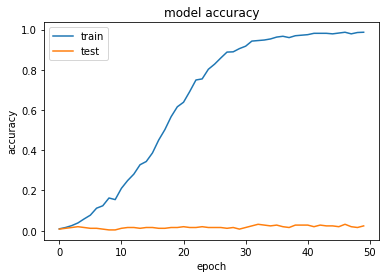

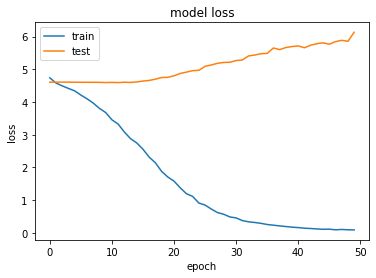

In [ ]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

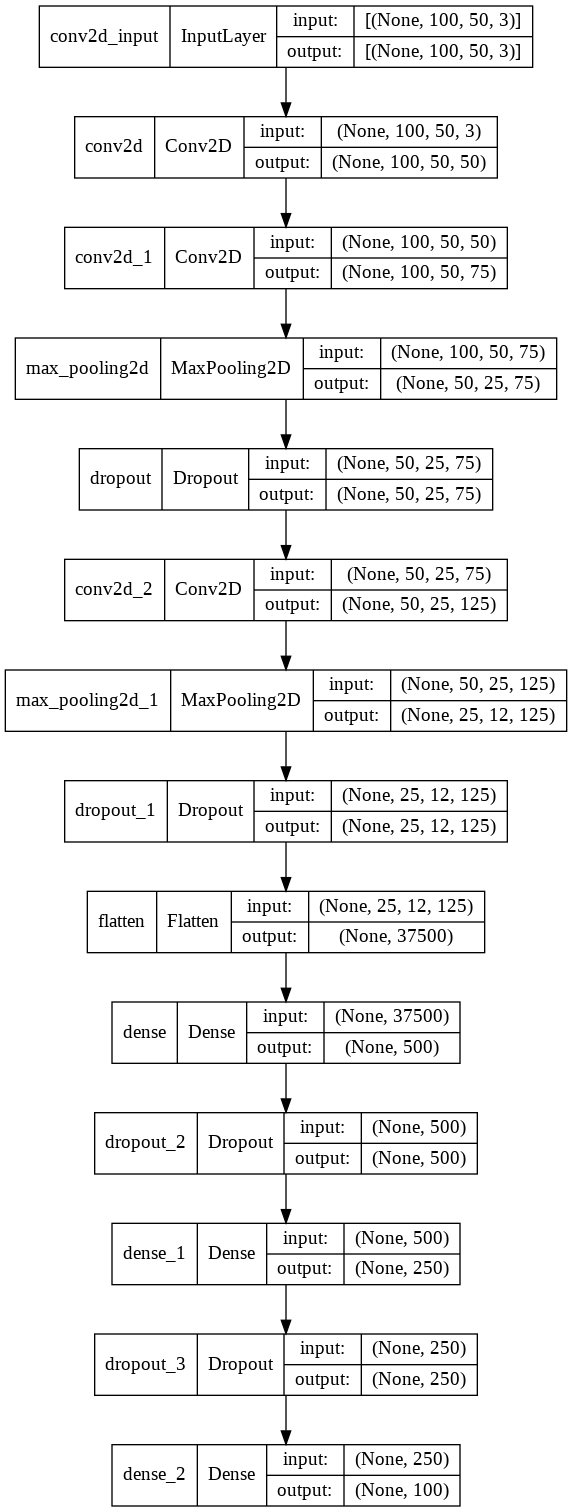

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model2.load_weights('/content/drive/MyDrive/assignment3/detectors/secondCNN/epochs:033-val_acc:0.032.hdf5')
rankacc(X_test, test_class, model2)

Score 5:  0.068 , Score 1:  0.032


In [ ]:
model2.save('/content/drive/MyDrive/assignment3/detectors/secondCNN')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/assignment3/detectors/secondCNN/assets


# THIRD TRY

In [ ]:
from keras.applications.vgg16 import VGG16 

# include top should be False to remove the softmax layer
pretrained_model = VGG16(include_top=False, weights='imagenet')

In [ ]:
from tensorflow.keras.utils import to_categorical
# extract train and val features
vgg_features_train = pretrained_model.predict(X_train)
vgg_features_val = pretrained_model.predict(X_test)
# OHE target column
train_target = to_categorical(y_train)
val_target = to_categorical(y_test)

In [ ]:
model3 = Sequential()
model3.add(Flatten(input_shape=(3,1,512)))
model3.add(Dense(100, activation='relu'))
model3.add(Dropout(0.5))
model3.add(BatchNormalization())
model3.add(Dense(100, activation='softmax'))

# compile the model
model3.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

In [ ]:
# train model using features generated from VGG16 model
filepath_model = "/content/drive/MyDrive/assignment3/detectors/thirdCNN/epochs:{epoch:03d}-val_acc:{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath_model, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model3.fit(vgg_features_train, train_target, epochs=50, batch_size=128, validation_data=(vgg_features_val, val_target), callbacks=callbacks_list)

Epoch 1/50
1/6 [====>.........................] - ETA: 0s - loss: 1.5005 - accuracy: 0.7266
Epoch 00001: val_accuracy improved from -inf to 0.10400, saving model to /content/drive/MyDrive/assignment3/detectors/thirdCNN/epochs:001-val_acc:0.104.hdf5
6/6 [==============================] - 0s 23ms/step - loss: 1.4107 - accuracy: 0.7253 - val_loss: 4.1538 - val_accuracy: 0.1040
Epoch 2/50
1/6 [====>.........................] - ETA: 0s - loss: 1.4574 - accuracy: 0.7578
Epoch 00002: val_accuracy improved from 0.10400 to 0.13200, saving model to /content/drive/MyDrive/assignment3/detectors/thirdCNN/epochs:002-val_acc:0.132.hdf5
6/6 [==============================] - 0s 23ms/step - loss: 1.4315 - accuracy: 0.7280 - val_loss: 4.1130 - val_accuracy: 0.1320
Epoch 3/50
1/6 [====>.........................] - ETA: 0s - loss: 1.4118 - accuracy: 0.7656
Epoch 00003: val_accuracy did not improve from 0.13200
6/6 [==============================] - 0s 11ms/step - loss: 1.3787 - accuracy: 0.7333 - val_loss

In [ ]:
model3.save('/content/drive/MyDrive/assignment3/detectors/thirdCNN')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/assignment3/detectors/thirdCNN/assets


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


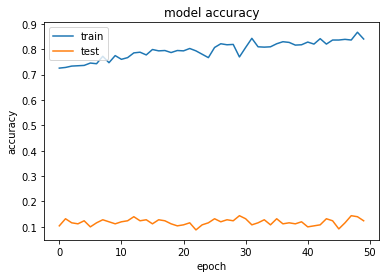

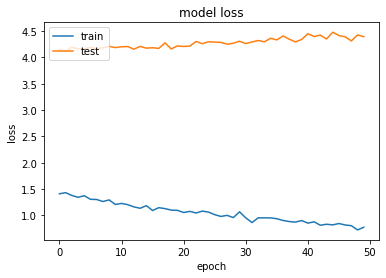

In [ ]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'][0:50])
plt.plot(history.history['val_accuracy'][0:50])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'][0:50])
plt.plot(history.history['val_loss'][0:50])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model3, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model3.load_weights('/content/drive/MyDrive/assignment3/detectors/thirdCNN/epochs:049-val_acc:0.172.hdf5')
#rankacc(X_test, test_class, model3)

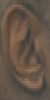

In [ ]:
img = cv2.resize(cv2.imread(filename), (50, 100), interpolation = cv2.INTER_AREA)
cv2_imshow(img)
prepred = pretrained_model.predict(np.array([X_train[0]]))
preds = model3.predict(prepred)

In [ ]:
y_pred_5 = []
y_pred_1 = []
for i in range(X_test.shape[0]):
  item = X_test[i]
  prepred = pretrained_model.predict(np.array([X_train[0]]))
  preds = model3.predict(prepred)
  preds = np.argsort(preds[0,:])[::-1][:5]
  if test_class[i] in preds: y_pred_5.append(1)
  else: y_pred_5.append(0)
  if test_class[i] == preds[0]: y_pred_1.append(1)
  else: y_pred_1.append(0)

score5 = sum(y_pred_5)/len(y_pred_5)
score1 = sum(y_pred_1)/len(y_pred_1)
print("Score 5: ", score5, ", Score 1: ", score1)

Score 5:  0.044 , Score 1:  0.012


# EDGE 


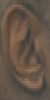

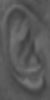

In [ ]:
filename = "/content/drive/MyDrive/assignment3/data/perfectly_detected_ears/test/0015.png"
img = cv2.resize(cv2.imread(filename), (50, 100), interpolation = cv2.INTER_AREA)
cv2_imshow(img)
from google.colab.patches import cv2_imshow
# Convert to graycsale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Blur the image for better edge detection
img_blur = cv2.GaussianBlur(img_gray, (3,3), 0)
cv2_imshow(img_blur)

In [ ]:
np.median(img_blur) 

55.0

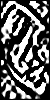

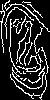

In [ ]:
edges = cv2.Canny(image=img_blur, threshold1=10, threshold2=50) # Canny Edge Detection
sobelxy = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=7)
# Display Canny Edge Detection Image
cv2_imshow(sobelxy)
cv2_imshow(edges)

In [ ]:
# read and process images
im_list = sorted(glob.glob(path_train + '/*.png', recursive=True))
images_train = []
for im_name in im_list:
  img = cv2.resize(cv2.imread(im_name), (100, 50), interpolation = cv2.INTER_AREA)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # Blur the image for better edge detection
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.Canny(image=img, threshold1=10, threshold2=50)
  #img = cv2.Sobel(src=img, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=7)
  images_train.append(img)

im_list = sorted(glob.glob(path_test + '/*.png', recursive=True))
images_test = []
for im_name in im_list:
  img = cv2.resize(cv2.imread(im_name), (100, 50), interpolation = cv2.INTER_AREA)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # Blur the image for better edge detection
  img = cv2.GaussianBlur(img, (3,3), 0) 
  img = cv2.Canny(image=img, threshold1=10, threshold2=50)
  #img = cv2.Sobel(src=img, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=7)
  images_test.append(img)

images_train = np.array(images_train)
images_test = np.array(images_test)

In [ ]:
X_train, y_train, X_test, y_test = images_train.astype('float32'), train_class, images_test.astype('float32'), test_class

X_train = X_train.reshape(X_train.shape[0], 100, 50, 1)
X_test = X_test.reshape(X_test.shape[0], 100, 50, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

In [ ]:
n_classes = len(set(list(y_train)+list(y_test)))
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

Shape before one-hot encoding:  (750,)
Shape after one-hot encoding:  (750, 100)


In [ ]:
# https://www.analyticsvidhya.com/blog/2020/02/learn-image-classification-cnn-convolutional-neural-networks-3-datasets/
# building a linear stack of layers with the sequential model
model = Sequential()

# convolutional layer
model.add(Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(100, 50, 1)))

# convolutional layer
model.add(Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(125, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# flatten output of conv
model.add(Flatten())

# hidden layer
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(100, activation='softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')


In [ ]:
filepath_model = "/content/drive/MyDrive/assignment3/detectors/first_norm_edgeCNN/epochs:{epoch:03d}-val_acc:{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath_model, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(X_train, Y_train, batch_size=128, epochs=50, validation_data=(X_test, Y_test), callbacks=callbacks_list)

Epoch 1/50
6/6 [==============================] - ETA: 0s - loss: 9.0251 - accuracy: 0.0107
Epoch 00001: val_accuracy improved from -inf to 0.01200, saving model to /content/drive/MyDrive/assignment3/detectors/first_norm_edgeCNN/epochs:001-val_acc:0.012.hdf5
6/6 [==============================] - 3s 452ms/step - loss: 9.0251 - accuracy: 0.0107 - val_loss: 4.6082 - val_accuracy: 0.0120
Epoch 2/50
6/6 [==============================] - ETA: 0s - loss: 4.6054 - accuracy: 0.0160
Epoch 00002: val_accuracy did not improve from 0.01200
6/6 [==============================] - 1s 219ms/step - loss: 4.6054 - accuracy: 0.0160 - val_loss: 4.6055 - val_accuracy: 0.0080
Epoch 3/50
6/6 [==============================] - ETA: 0s - loss: 4.6019 - accuracy: 0.0120
Epoch 00003: val_accuracy did not improve from 0.01200
6/6 [==============================] - 1s 209ms/step - loss: 4.6019 - accuracy: 0.0120 - val_loss: 4.6057 - val_accuracy: 0.0080
Epoch 4/50
6/6 [==============================] - ETA: 0s - 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


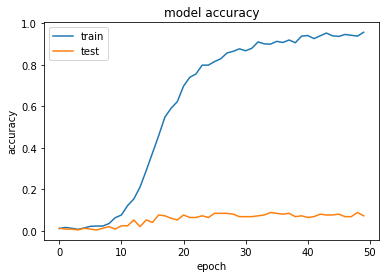

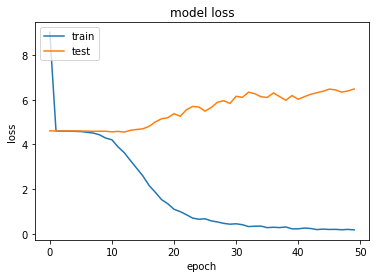

In [ ]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.load_weights('/content/drive/MyDrive/assignment3/detectors/first_norm_edgeCNN/epochs:035-val_acc:0.088.hdf5')
rankacc(X_test, test_class, model)

Score 5:  0.212 , Score 1:  0.088


# NORMALIZATION

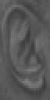

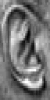

In [ ]:
from google.colab.patches import cv2_imshow
filename = "/content/drive/MyDrive/assignment3/data/perfectly_detected_ears/test/0015.png"
img = cv2.resize(cv2.imread(filename, cv2.IMREAD_GRAYSCALE), (50, 100), interpolation = cv2.INTER_AREA)
cv2_imshow(img)

norm_img = np.zeros((50, 100))
norm_img = cv2.normalize(img, norm_img, 0, 255, cv2.NORM_MINMAX)
cv2_imshow(norm_img)

In [ ]:
# read and process images
im_list = sorted(glob.glob(path_train + '/*.png', recursive=True))
images_train = []
for im_name in im_list:
  img = cv2.resize(cv2.imread(im_name, cv2.IMREAD_GRAYSCALE), (100, 50), interpolation = cv2.INTER_AREA)
  norm_img = np.zeros((100, 50))
  img = cv2.normalize(img, norm_img, 0, 255, cv2.NORM_MINMAX)
  images_train.append(img)

im_list = sorted(glob.glob(path_test + '/*.png', recursive=True))
images_test = []
for im_name in im_list:
  img = cv2.resize(cv2.imread(im_name, cv2.IMREAD_GRAYSCALE), (100, 50), interpolation = cv2.INTER_AREA)
  norm_img = np.zeros((100, 50))
  img = cv2.normalize(img, norm_img, 0, 255, cv2.NORM_MINMAX)
  images_test.append(img)

images_train = np.array(images_train)
images_test = np.array(images_test)

In [ ]:
# NORM + EDGE
im_list = sorted(glob.glob(path_train + '/*.png', recursive=True))
images_train = []
for im_name in im_list:
  img = cv2.resize(cv2.imread(im_name), (100, 50), interpolation = cv2.INTER_AREA)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  norm_img = np.zeros((100, 50))
  img = cv2.normalize(img, norm_img, 0, 255, cv2.NORM_MINMAX)
  # Blur the image for better edge detection
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.Sobel(src=img, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=7)
  images_train.append(img)

im_list = sorted(glob.glob(path_test + '/*.png', recursive=True))
images_test = []
for im_name in im_list:
  img = cv2.resize(cv2.imread(im_name), (100, 50), interpolation = cv2.INTER_AREA)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  norm_img = np.zeros((100, 50))
  img = cv2.normalize(img, norm_img, 0, 255, cv2.NORM_MINMAX)
  # Blur the image for better edge detection
  img = cv2.GaussianBlur(img, (3,3), 0) 
  img = cv2.Sobel(src=img, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=7)
  images_test.append(img)

images_train = np.array(images_train)
images_test = np.array(images_test)

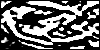

In [ ]:
cv2_imshow(img)

# AUGMENTATION

In [ ]:
from keras_preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.0,
    height_shift_range=0.0,
    horizontal_flip=True,
    validation_split=0.0)
datagen.fit(X_train)

In [ ]:
from keras.utils import to_categorical
y_trainn = to_categorical(y_train, 100)
y_testt = to_categorical(y_test, 100)

ImportError: ignored

In [ ]:
# https://www.analyticsvidhya.com/blog/2020/02/learn-image-classification-cnn-convolutional-neural-networks-3-datasets/
# building a linear stack of layers with the sequential model
model = Sequential()

# convolutional layer
model.add(Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(100, 50, 1)))

# convolutional layer
model.add(Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(125, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# flatten output of conv
model.add(Flatten())

# hidden layer
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(100, activation='softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
filepath_model = "/content/drive/MyDrive/assignment3/detectors/norm_augmCNN/epochs:{epoch:03d}-val_acc:{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath_model, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(datagen.flow(X_train, Y_train, batch_size=32,
         subset='training'),
         validation_data=(X_test, Y_test), epochs=200, callbacks=callbacks_list)

ValueError: ignored

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


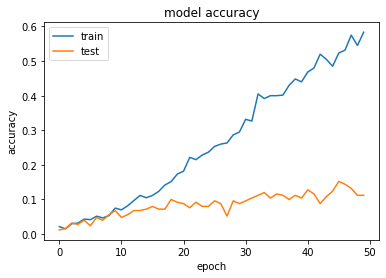

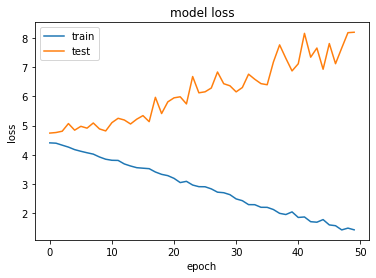

In [ ]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()